# Package Dependencies — Graph (Prototype)

This test notebook loads `Package_Dependencies.csv`  
and generates an interactive graph of package dependencies:

- **Node** = package (`originPackage` / `destinationPackage`)
- **Directed edge** = dependency (`origin → destination`)
- **Edge thickness** = `totalDependencies`
- It is limited to the **N “strongest” packages** so the graph remains readable (default is 3, adjustable in the cell).


## How to interpret the dependency colors

### 🔵 Blue edges — normal dependencies
Blue arrows represent **regular package dependencies**.  
They show:
- which package depends on which,
- how information flows,
- which APIs are being used,
- and how many times (the weight number on the edge).

### 🔴 Red edges — part of the longest dependency path
Red arrows are **not ordinary dependencies**.  
They highlight the edges that belong to the **longest dependency chain** in the entire system.
This means they represent:
- the deepest structural path,
- the “main backbone” of the project,
- the chain where changes have the strongest structural impact.

### 🟧 Orange edges — contributors to the longest path
Orange edges are dependencies that:
- are **not directly on** the longest path,
- but **support** or feed into that critical path.
They indirectly influence the main structural chain.

---

## Edge thickness
The arrow thickness (`penwidth`) comes from the normalized dependency weight:

- More package-to-package dependencies → **thicker arrow**
- Fewer dependencies → **thinner arrow**


In [1]:
import os
from pathlib import Path

import pandas as pd
from neo4j import GraphDatabase
from graphviz import Source
from IPython.display import display

pd.set_option("future.no_silent_downcasting", True)

# Neo4j connection (password comes from environment variable for security)
driver = GraphDatabase.driver(
    uri="bolt://localhost:7687",
    auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD"))
)
driver.verify_connectivity()
print("Connected to Neo4j.")

def get_cypher_query_from_file(filename: Path) -> str:
    """Read a Cypher file and return its content as a single string."""
    with open(filename, encoding="utf-8") as file:
        return " ".join(file.readlines())

def query_cypher_to_data_frame(filename: Path, parameters_=None) -> pd.DataFrame:
    """Execute a Cypher query from a file and return the result as a pandas DataFrame."""
    if parameters_ is None:
        parameters_ = {}
    query = get_cypher_query_from_file(filename)
    records, summary, keys = driver.execute_query(query, parameters_=parameters_)
    return pd.DataFrame([r.values() for r in records], columns=keys)


Connected to Neo4j.


In [2]:
def create_directed_unweighted_projection(parameters: dict) -> bool:
    """
    Create a directed projection in GDS for package dependencies.

    It uses:
      - Node label: dependencies_projection_node (e.g. "Package")
      - Relationship: DEPENDS_ON
      - Relationship weight property: dependencies_projection_weight_property (e.g. "weight")

    The projected graph name will be: dependencies_projection + "-cleaned".
    """

    base = Path("../cypher/Dependencies_Projection")

    # 0) Check if there is any data that can be projected
    df_check = query_cypher_to_data_frame(base / "Dependencies_0_Check_Projectable.cypher", parameters)
    if df_check.empty:
        print("No projectable data for dependencies projection (Check_Projectable is empty).")
        return False

    graph_name = parameters["dependencies_projection"] + "-cleaned"

    # 1) Try to drop an existing projection with the same name (ignore errors if it does not exist)
    try:
        drop_query = """
        CALL gds.graph.drop($graph_name, false)
        YIELD graphName
        RETURN graphName
        """
        records, summary, keys = driver.execute_query(
            drop_query,
            parameters_={"graph_name": graph_name}
        )
        if records:
            print(f"Previous projection '{graph_name}' dropped.")
    except Exception as e:
        print(f"[info] No previous projection '{graph_name}' to drop (or harmless error): {e}")

    # 2) Create the new minimal projection
    project_query = """
    CALL gds.graph.project(
      $graph_name,
      $dependencies_projection_node,
      'DEPENDS_ON',
      { relationshipProperties: [$dependencies_projection_weight_property] }
    )
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName, nodeCount, relationshipCount
    """

    records, summary, keys = driver.execute_query(
        project_query,
        parameters_={
            "graph_name": graph_name,
            "dependencies_projection_node": parameters["dependencies_projection_node"],
            "dependencies_projection_weight_property": parameters["dependencies_projection_weight_property"],
        }
    )

    df_proj = pd.DataFrame([r.values() for r in records], columns=keys)
    print("GDS projection created:")
    display(df_proj)

    return True


In [3]:
package_path_finding_parameters = {
    "dependencies_projection": "java-package-path-finding-notebook",
    "dependencies_projection_node": "Package",  # Node label in your model
    "dependencies_projection_weight_property": "weight",  # Relationship weight property
}

is_package_data_available = create_directed_unweighted_projection(package_path_finding_parameters)
print("is_package_data_available:", is_package_data_available)


Previous projection 'java-package-path-finding-notebook-cleaned' dropped.
GDS projection created:


,graphName,nodeCount,relationshipCount
0,java-package-path-finding-notebook-cleaned,6846,42966


is_package_data_available: True


In [14]:
# This controls how many longest paths are taken into account by the Cypher query.
# It is passed as $pathLimit into the query file.
pathLimit = 3

# Extend parameters dict with pathLimit so the Cypher query can use $pathLimit
package_path_finding_parameters_with_limit = {
    **package_path_finding_parameters,
    "pathLimit": pathLimit,
}
print("Using pathLimit =", pathLimit)


Using pathLimit = 3


In [15]:
if not is_package_data_available:
    print("[info] No projected package data available. Check the projection.")
else:
    # Adjust the file name if you changed a different .cypher
    cypher_path = Path("../cypher/Path_Finding/Path_Finding_6_Longest_paths_contributors_for_graphviz_custom.cypher")
    df_longest = query_cypher_to_data_frame(cypher_path, package_path_finding_parameters_with_limit)

    print("Rows returned:", len(df_longest))
    print("Columns:", list(df_longest.columns))
    display(df_longest.head())


Rows returned: 61
Columns: ['graphVizDotNotationLine']


,graphVizDotNotationLine
0,"""session"" -> ""logging"" [label=2; penwidth=1.0;..."
1,"""authentication"" -> ""logging"" [label=15; penwi..."
2,"""csrf"" -> ""logging"" [label=4; penwidth=1.0; ];"
3,"""logout"" -> ""logging"" [label=3; penwidth=1.0; ];"
4,"""session"" -> ""logging"" [label=5; penwidth=1.0; ];"


In [16]:
template_body = """
fontname = "Helvetica,Arial,sans-serif";
node [fontname = "Helvetica,Arial,sans-serif";];
edge [fontname = "Helvetica,Arial,sans-serif"; fontsize = 10;];
node [style = filled; fillcolor = "0.560 0.400 0.999";];
node [color = "0.560 0.900 0.700";];
edge [color = "0.560 0.900 0.700";];
""".rstrip("\\n")


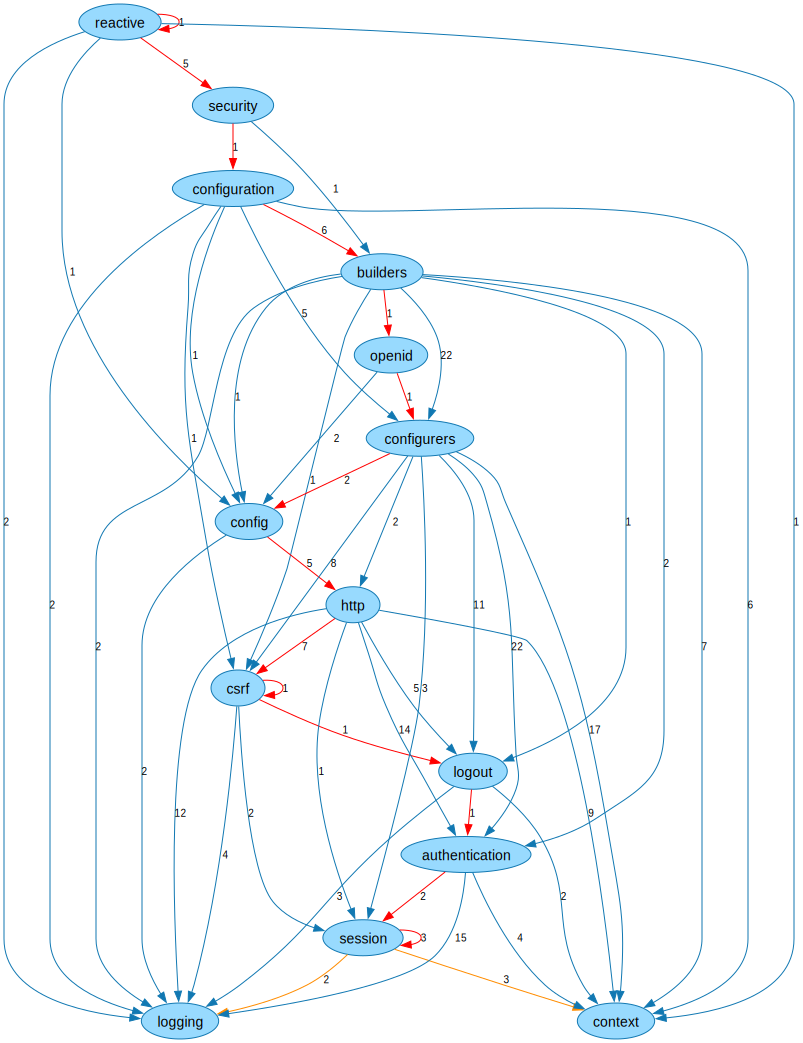

In [17]:
from graphviz import Source
from IPython.display import display

# Build DOT source and render with GraphViz
if "df_longest" not in globals():
    print("[info] df_longest is not defined; run the Cypher query cell first.")
elif df_longest.empty:
    print("[info] Longest paths query returned no data.")
else:
    col_name = "graphVizDotNotationLine"
    if col_name not in df_longest.columns:
        raise ValueError(f"Column '{col_name}' not found in query result.")

    # Collect edge lines (each line is a full DOT edge line created in Cypher)
    edge_lines = [
        str(line)
        for line in df_longest[col_name].dropna().unique()
    ]

    # Assemble DOT graph using the original JohT template body
    dot_lines = []
    dot_lines.append("strict digraph lightblue_template {")
    dot_lines.append(template_body)  # <-- this is the block with fontname/node/edge defaults
    for line in edge_lines:
        dot_lines.append("    " + line)
    dot_lines.append("}")

    dot_source = "\n".join(dot_lines)

    # If you want to debug the DOT text, you can uncomment this:
    # print(dot_source)

    # Create GraphViz Source and display it in the notebook
    src = Source(dot_source)
    display(src)


In [18]:
print("Done")

Done
